In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Step 1
First, we are going to read the csv, and get a quick overlook on the basic shape of the data etc.

In [76]:
df = pd.read_csv('data/ClimateDataBasel.csv', header=None); # There is no headers, will add in next block

Below we will define the missing columns from the dataset.

In [77]:
df.columns = [
    "temp_min", 
    "temp_max", 
    "temp_avg", 
    "humidity_min", 
    "humidity_max",
    "humidity_avg", 
    "pressure_min", 
    "pressure_max", 
    "pressure_avg",
    "rain", 
    "snow", 
    "solar", 
    "wind_speed", 
    "wind_dir",
    "visibility", 
    "air_quality", 
    "ozone", 
    "uv_index"
]

Now we are going to get an idea of the general shape of the data, and see if we have any obvious abnormalities. 
We will also check if there are any features with incorrect data-types.

In [78]:
df.shape, df.columns.tolist()
df.head()
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp_min      1763 non-null   float64
 1   temp_max      1763 non-null   float64
 2   temp_avg      1763 non-null   float64
 3   humidity_min  1763 non-null   int64  
 4   humidity_max  1763 non-null   int64  
 5   humidity_avg  1763 non-null   float64
 6   pressure_min  1763 non-null   float64
 7   pressure_max  1763 non-null   float64
 8   pressure_avg  1763 non-null   float64
 9   rain          1763 non-null   float64
 10  snow          1763 non-null   float64
 11  solar         1763 non-null   float64
 12  wind_speed    1763 non-null   float64
 13  wind_dir      1763 non-null   float64
 14  visibility    1763 non-null   float64
 15  air_quality   1763 non-null   float64
 16  ozone         1763 non-null   float64
 17  uv_index      1763 non-null   float64
dtypes: float64(16), int64(2)
mem

,count,mean,std,min,25%,50%,75%,max
temp_min,1763.0,8.738776,7.803700,-12.519471,1.700529,10.210529,15.530529,25.820530
temp_max,1763.0,16.779298,9.647769,-4.389471,8.200529,17.400530,25.190529,36.700527
temp_avg,1763.0,12.717350,8.788555,-7.628222,4.689279,14.618446,20.432404,30.425112
humidity_min,1763.0,54.092456,12.949827,19.000000,44.000000,54.000000,64.000000,93.000000
humidity_max,1763.0,87.004538,7.892077,53.000000,82.000000,88.000000,93.000000,100.000000
humidity_avg,1763.0,71.040509,10.012178,38.333332,63.520834,72.000000,78.750000,95.250000
pressure_min,1763.0,1014.690925,8.848251,976.100000,1010.300000,1014.600000,1019.300000,1043.600000
pressure_max,1763.0,1020.364492,8.014133,981.400000,1015.900000,1019.500000,1024.400000,1049.900000
pressure_avg,1763.0,1017.576393,8.282298,978.450000,1013.233400,1016.954040,1021.760405,1047.095800
rain,1763.0,1.502893,3.496710,0.000000,0.000000,0.000000,1.200000,37.399994


Lets next double check if there are any missing values

In [79]:
print(df.isnull().sum())  # count missing per column
print(df.info())  # check data types

temp_min        0
temp_max        0
temp_avg        0
humidity_min    0
humidity_max    0
humidity_avg    0
pressure_min    0
pressure_max    0
pressure_avg    0
rain            0
snow            0
solar           0
wind_speed      0
wind_dir        0
visibility      0
air_quality     0
ozone           0
uv_index        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp_min      1763 non-null   float64
 1   temp_max      1763 non-null   float64
 2   temp_avg      1763 non-null   float64
 3   humidity_min  1763 non-null   int64  
 4   humidity_max  1763 non-null   int64  
 5   humidity_avg  1763 non-null   float64
 6   pressure_min  1763 non-null   float64
 7   pressure_max  1763 non-null   float64
 8   pressure_avg  1763 non-null   float64
 9   rain          1763 non-null   float64
 10  snow          1763 non-null   float

Okay, it doesnt look like there are any missing  values.

Now, lets graph this data to get an idea of the distributions. 

<Figure size 1200x800 with 0 Axes>

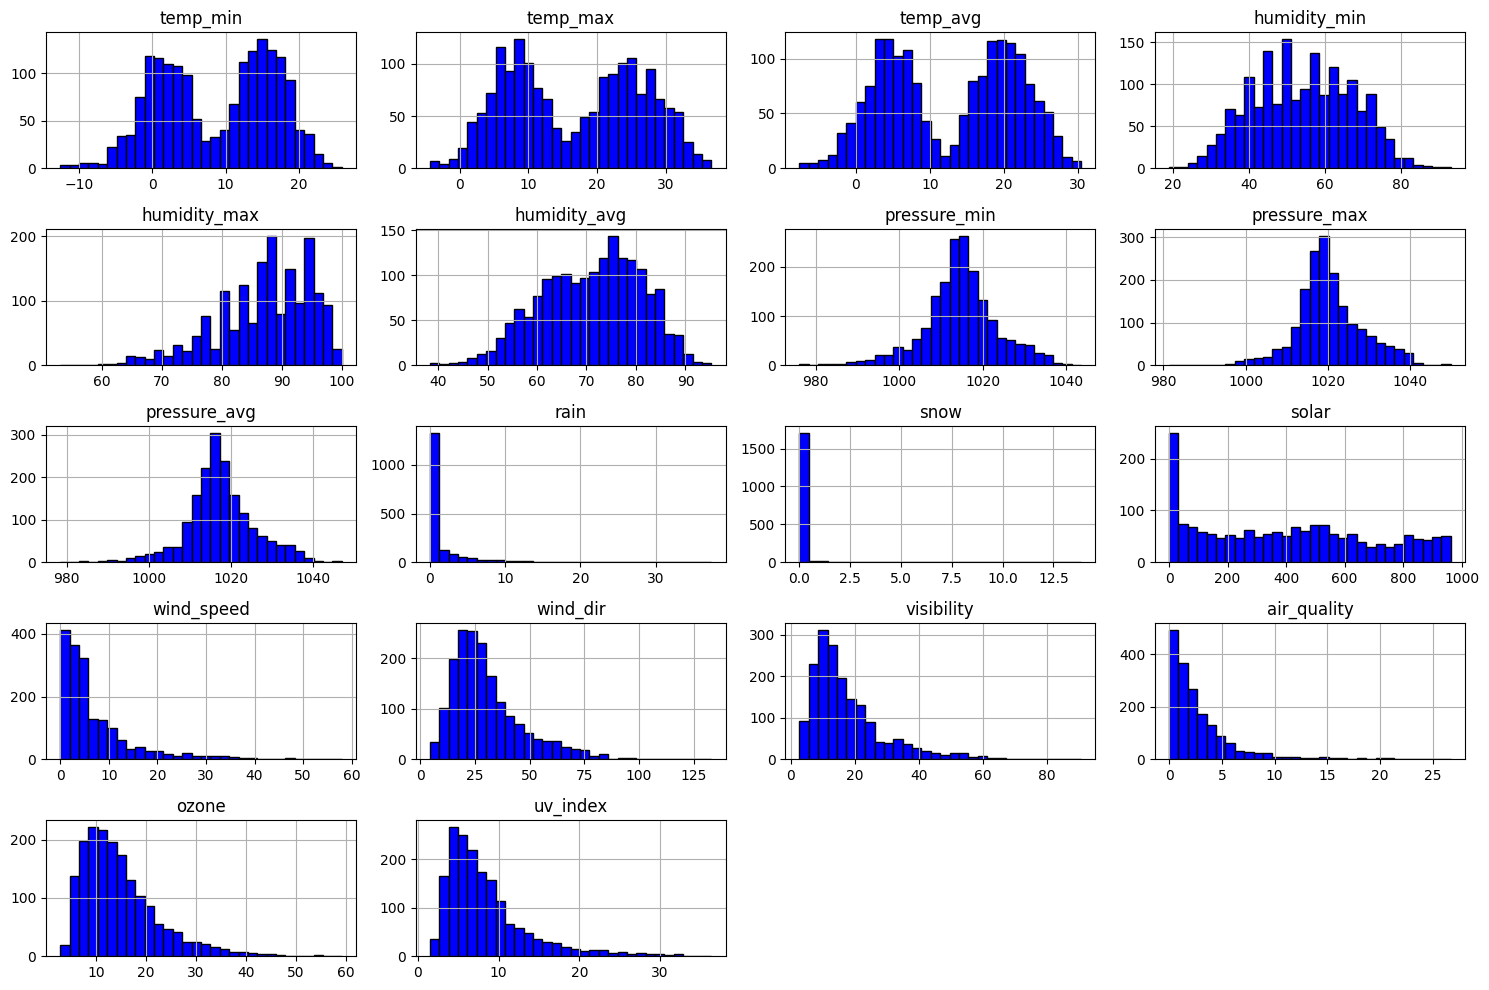

In [80]:
plt.figure(figsize=(12,8)) 
df.hist(bins=30, figsize=(15,10), color='blue', edgecolor='black')
plt.tight_layout()

Now lets standardise and normalise our data.
In order to do this, we will be using the sci-learn StandardScaler.


In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler();
scaled_data = scaler.fit_transform(df)

# now to convert back to a dataframe

scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df.head()



# normalise data

from sklearn.preprocessing import MinMaxScaler

normaliser = MinMaxScaler(feature_range=(0,1));
normalised_data = normaliser.fit_transform(df)
normalised_df = pd.DataFrame(normalised_data, columns=df.columns)
normalised_df.head()

,temp_min,temp_max,temp_avg,humidity_min,humidity_max,humidity_avg,pressure_min,pressure_max,pressure_avg,rain,snow,solar,wind_speed,wind_dir,visibility,air_quality,ozone,uv_index
0,0.537819,0.534437,0.553784,0.567568,0.914894,0.694729,0.548148,0.540146,0.543490,0.005348,0.0,0.364303,0.055901,0.148045,0.107855,0.066998,0.133575,0.147563
1,0.616328,0.556826,0.594352,0.540541,0.872340,0.669839,0.560000,0.513869,0.532322,0.050802,0.0,0.298492,0.111801,0.162011,0.138184,0.156010,0.238031,0.204255
2,0.595722,0.549039,0.575399,0.702703,0.914894,0.795022,0.580741,0.527007,0.552655,0.002674,0.0,0.131214,0.055901,0.153631,0.114159,0.076063,0.149319,0.139890
3,0.599113,0.714773,0.655330,0.472973,0.829787,0.690337,0.589630,0.544526,0.565402,0.000000,0.0,0.915788,0.037267,0.122905,0.076844,0.029963,0.152750,0.091657
4,0.648670,0.730105,0.722933,0.378378,0.744681,0.496340,0.586667,0.573723,0.578820,0.000000,0.0,0.988863,0.012422,0.089385,0.032373,0.014124,0.063253,0.052092


## Outlier Detection

We are going to be calculating z-scores in order to detect outliers:

First, we use k=4, as a strict approach to detect extreme outliers. 
Then, if needed, we can relax k to 3.
my focus is removing the **smallest** amount of data points possible and only removing extreme outliers.

In [82]:
# define k 
k = 8

# get mean and standard deviation
mean = df.mean()
stdev = df.std()

# calculate zscores. These are the number of standard deviations away from the mean a data point lies.
z_scores = np.abs((df - mean) / stdev)

# if a row has any of these, mark as an outlier.
outliers = (z_scores > k).any(axis=1)


# Now, we need to display these outliers in a clear way in order to determine if they should be removed.

outlier_data = df[outliers]
print(f"Number of outliers detected: {outlier_data.shape[0]}")
print(f"Outlier ratio: {outlier_data.shape[0] / df.shape[0]:.2%}")

# check if any temp_max values are less than temp_min values
temp_anomalies = df[df['temp_max'] < df['temp_min']]
print(f"Number of temperature anomalies detected: {temp_anomalies.shape[0]}")

# check avg temp values are within min and max
temp_avg_anomalies =    df[(df['temp_avg'] < df['temp_min'])
                        | (df['temp_avg'] > df['temp_max'])]
print(f"Number of temperature average anomalies detected: {temp_avg_anomalies.shape[0]}")


# check if any humidity_max values are less than humidity_min values
humidity_anomalies = df[df['humidity_max'] < df['humidity_min']]
print(f"Number of humidity anomalies detected: {humidity_anomalies.shape[0]}")


# check avg humidity values are within min and max
humidity_avg_anomalies =    df[(df['humidity_avg'] < df['humidity_min'])
                            | (df['humidity_avg'] > df['humidity_max'])]
print(f"Number of humidity average anomalies detected: {humidity_avg_anomalies.shape[0]}")

# check if any pressure_max values are less than pressure_min values
pressure_anomalies = df[df['pressure_max'] < df['pressure_min']]
print(f"Number of pressure anomalies detected: {pressure_anomalies.shape[0]}")

# check avg pressure values are within min and max
pressure_avg_anomalies =    df[(df['pressure_avg'] < df['pressure_min'])
                            | (df['pressure_avg'] > df['pressure_max'])]
print(f"Number of pressure average anomalies detected: {pressure_avg_anomalies.shape[0]}")

outlier_data.head(10)



Number of outliers detected: 8
Outlier ratio: 0.45%
Number of temperature anomalies detected: 0
Number of temperature average anomalies detected: 0
Number of humidity anomalies detected: 0
Number of humidity average anomalies detected: 0
Number of pressure anomalies detected: 0
Number of pressure average anomalies detected: 0


,temp_min,temp_max,temp_avg,humidity_min,humidity_max,humidity_avg,pressure_min,pressure_max,pressure_avg,rain,snow,solar,wind_speed,wind_dir,visibility,air_quality,ozone,uv_index
97,1.740529,3.590529,2.610529,92,98,93.875000,996.4,1004.0,999.14180,33.300000,0.000000,0.00000,0.720000,24.119999,14.550000,2.456086,17.808994,11.761481
115,-1.809471,4.540529,1.060112,93,96,95.250000,995.1,1007.1,1000.16656,21.500000,13.860001,0.00000,5.040000,46.440000,22.095000,2.623736,26.385706,12.197314
224,15.280529,22.820530,18.698027,62,97,89.250000,1007.9,1013.4,1009.88330,36.200000,0.000000,0.00000,1.800000,39.960000,16.515000,1.332000,19.065754,7.348020
461,0.300529,4.090528,2.331362,77,95,85.708336,1003.3,1006.8,1005.43750,8.600000,5.810000,234.57092,4.320000,55.440000,31.050001,2.412355,22.986168,14.513318
463,-2.889471,2.140528,-0.554888,70,96,87.458336,1002.9,1020.1,1009.50830,10.500000,6.860001,35.46330,8.640000,70.920000,25.214998,5.763114,36.312576,14.567604
525,-1.969471,3.810529,0.807195,53,95,79.208336,1004.1,1014.6,1011.43744,9.600000,6.719999,211.91489,18.359999,59.399998,30.044996,11.566178,27.973269,18.295599
605,17.410528,20.800530,19.512197,58,95,73.833336,1014.3,1022.0,1017.44165,37.399994,0.000000,70.21667,3.600000,36.000000,19.694998,0.842431,14.417629,7.479879
1707,18.200530,21.700530,19.958445,72,95,86.083336,1008.4,1013.1,1010.25006,31.300000,0.000000,0.00000,4.320000,30.960001,18.119997,1.358379,12.897722,7.564203


72 Outliers were detected, which is around 4.08% of the total data set.

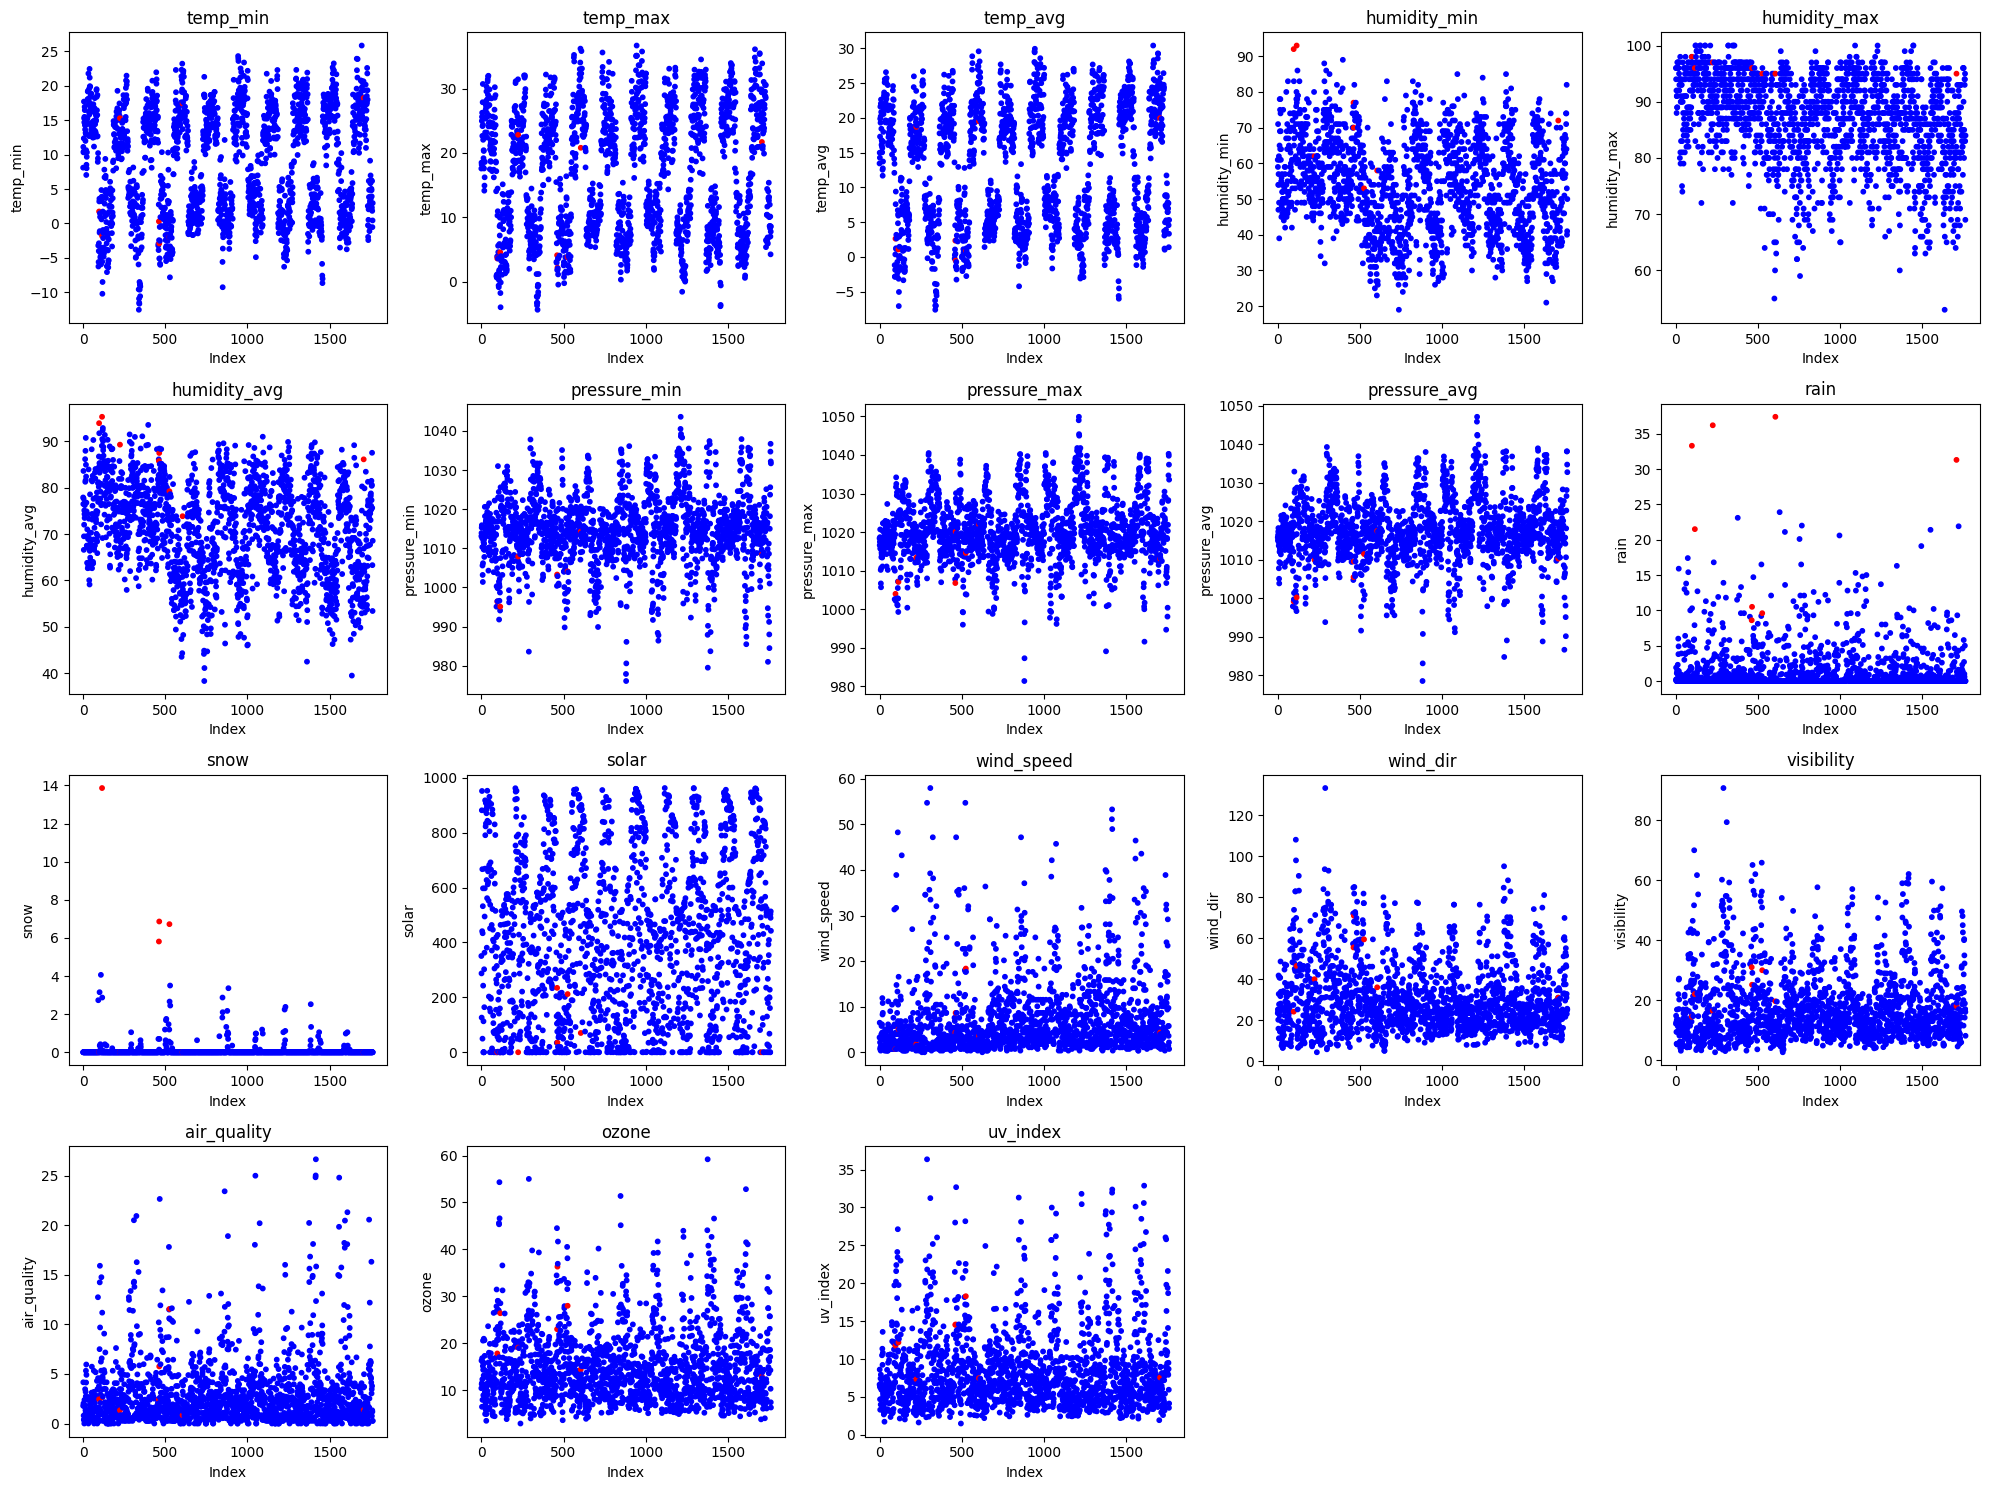

In [83]:
# draw scatter graphs of all the features, highlighting the outliers in red
# small dots


plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns):
    plt.subplot(4, 5, i + 1)
    plt.scatter(df.index, df[column], c=outliers.map({True: 'red', False: 'blue'}), s=10)
    plt.title(column)
    plt.xlabel('Index')
    plt.ylabel(column)
plt.tight_layout()
plt.show()


After looking through these outliers manually, all of these seem normal. And do not seem like erroneous values that need to be removed. In a weather system especially, outliers or extreme weather events are events of extreme importance and the largest amount of interest. so unless there is a faulty reading, there is no need to remove data.

Next, in order to begin clustering this data, we must remove any fields that may confuse the clustering process.

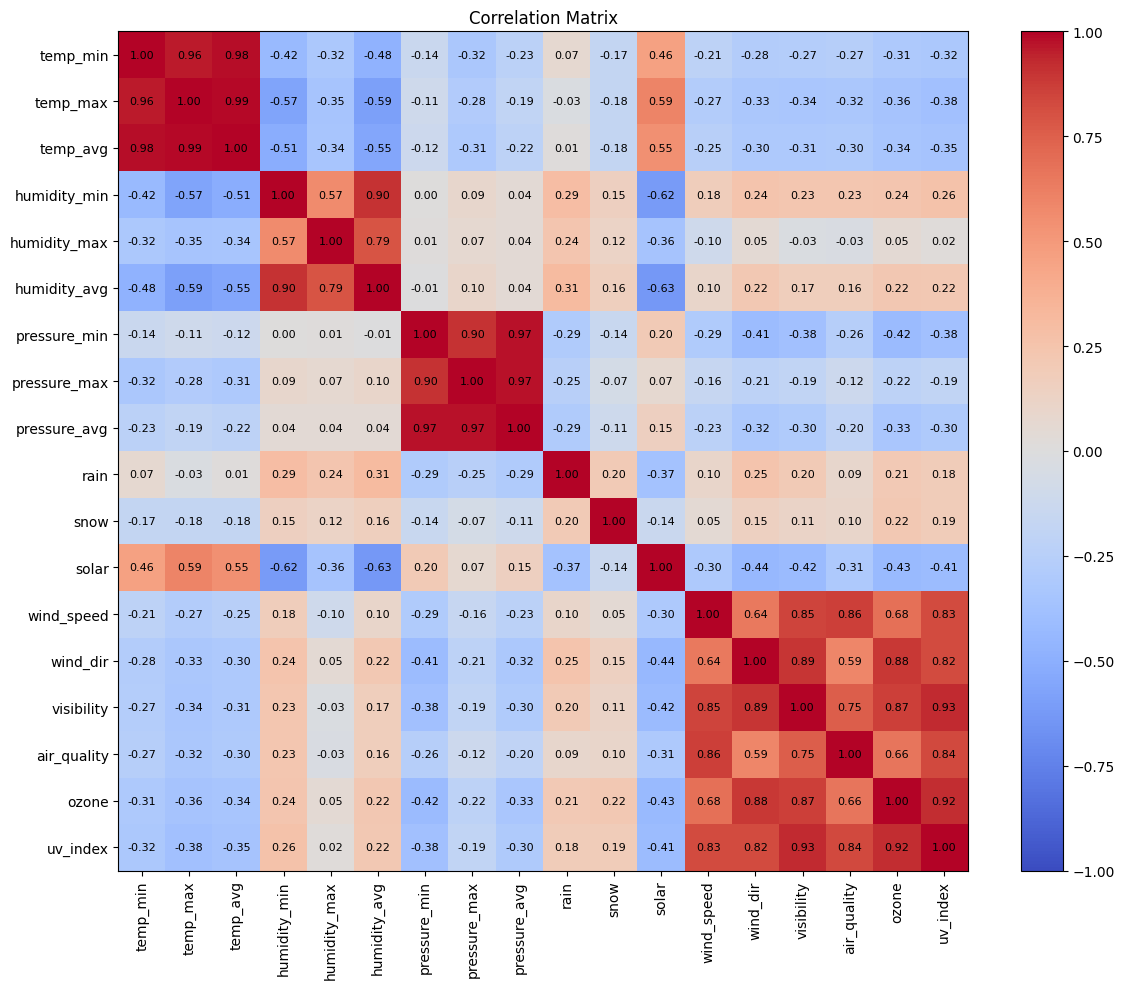

In [84]:
# correlaton grid 

import numpy as np

plt.figure(figsize=(12, 10))
correlation_matrix = scaled_df.corr()

# Create heatmap using matplotlib
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

# Add colorbar
plt.colorbar(im)

# Set ticks and labels
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Annotate cells with correlation values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                ha='center', va='center', color='black', fontsize=8)

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Now, obviously we can see that the min max and avg variables are redundant for this type of analysis and provide a lot of collinearity. So we shall now do this again with the min and max removed.
We may change this if other interesting correlations are found

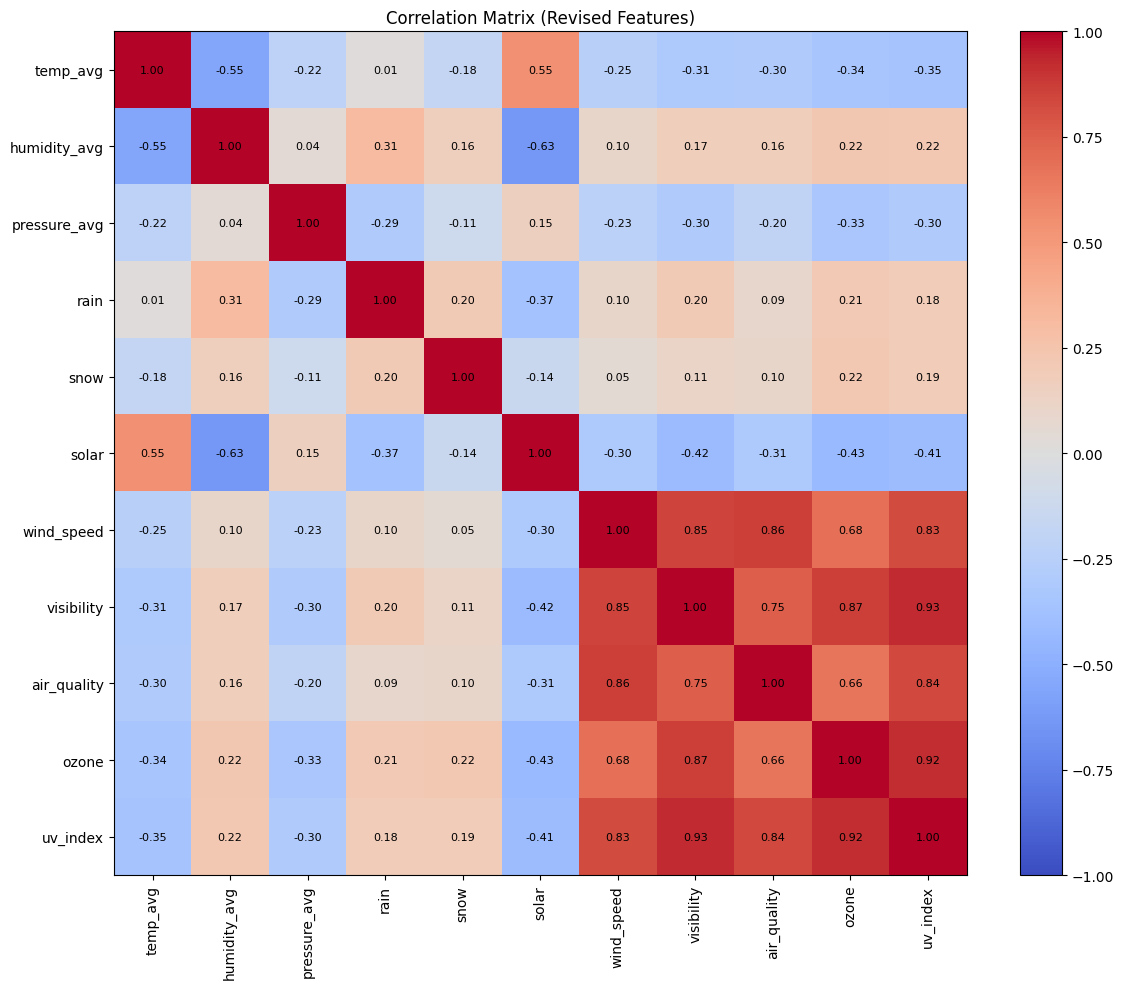

In [85]:
# make another correlation grid without min and max ones

revised_features = [
    "temp_avg", 
    "humidity_avg", 
    "pressure_avg", 
    "rain", 
    "snow", 
    "solar", 
    "wind_speed",
    "visibility", 
    "air_quality", 
    "ozone", 
    "uv_index"
]

plt.figure(figsize=(12, 10))
correlation_matrix = scaled_df[revised_features].corr()

# Create heatmap using matplotlib
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

# Add colorbar
plt.colorbar(im)

# Set ticks and labels
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Annotate cells with correlation values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                ha='center', va='center', color='black', fontsize=8)

plt.title('Correlation Matrix (Revised Features)')
plt.tight_layout()
plt.show()

Now we are going to run pca in order to reduce dimensionality and remove redundancy.


Explained variance ratio for each component: [0.37603558 0.23182644 0.13305751 0.06557006 0.0538974  0.03871224
 0.0316208  0.02481704]
Number of components kept: 8


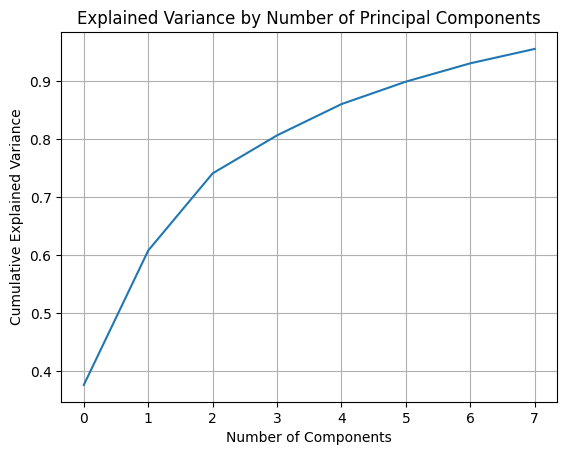

In [86]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(scaled_df)

print("Explained variance ratio for each component:", pca.explained_variance_ratio_)
print("Number of components kept:", pca.n_components_)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

In [87]:
import pandas as pd

pc_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
data_pca_df = pd.DataFrame(pca_result, columns=pc_columns)
data_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.392107,0.725060,1.353195,-0.028575,-0.561134,-0.783203,0.133879,-0.021450
1,0.270626,-0.055227,1.021031,0.491291,-0.382865,-0.543878,-0.125368,0.064707
2,0.024741,1.054220,1.831611,0.553390,-0.739038,-0.809868,-0.113552,-0.847749
3,-1.841947,0.147989,0.761246,0.186668,-0.182482,-1.260544,0.483900,0.626571
4,-3.060150,-0.210572,0.234987,-0.142067,0.052518,-0.823181,0.184763,0.736311


Now time to run K-means clustering

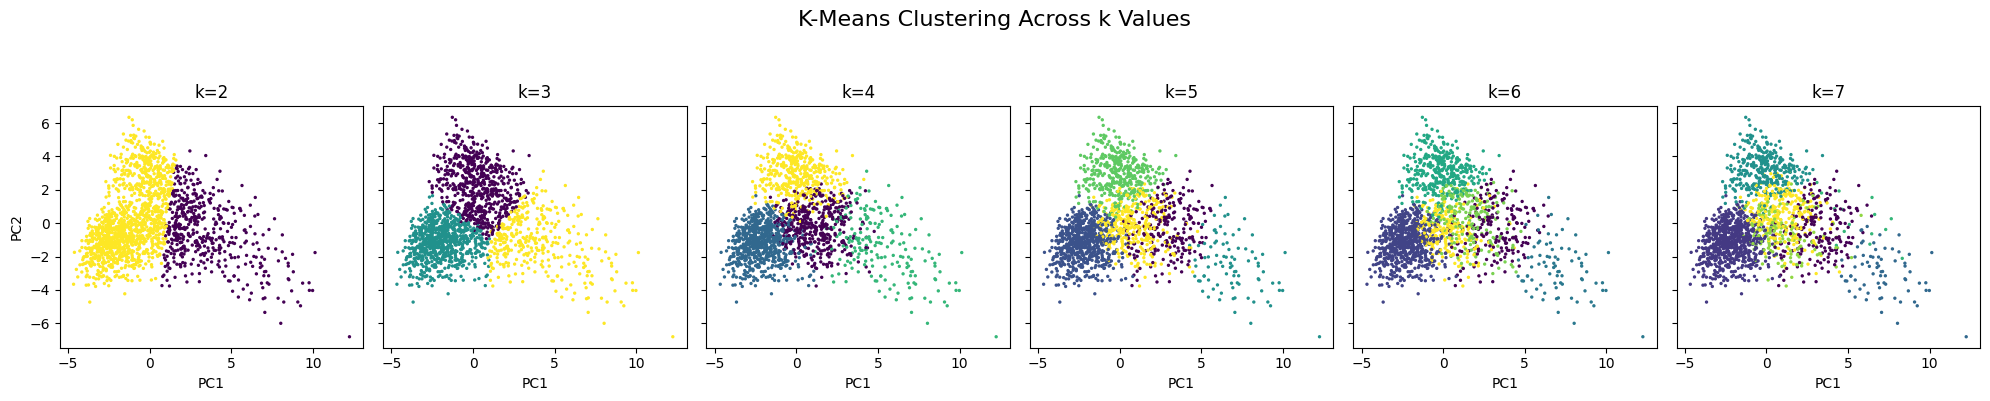

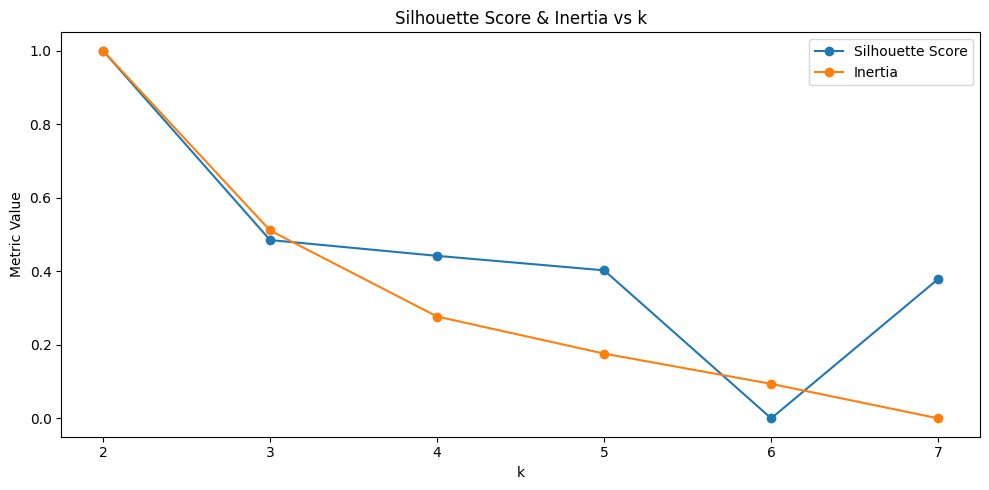

In [88]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


k_values = [2, 3, 4, 5, 6, 7]
pc1 = data_pca_df['PC1'].values
pc2 = data_pca_df['PC2'].values

fig, axes = plt.subplots(1, len(k_values), figsize=(20, 4), sharex=True, sharey=True)
plt.suptitle('K-Means Clustering Across k Values', fontsize=16, y=1.02)

# plot and calculate silhouette scores for each k and elbow method inertia
# plot these sillhouette scores and inertia values on a graph below the kmeans plots

# set up plot for silhouette scores and inertia value


silhouette_scores = []
inertia_values = []



for j, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_pca_df[pc_columns])  # Use 8 PCs
    ax = axes[j]
    scatter = ax.scatter(pc1, pc2, c=labels, cmap='viridis', s=2, alpha=1)
    ax.set_title(f'k={k}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.label_outer()


    # calculate silhouette score and inertia
    silhouette_scores.append(silhouette_score(data_pca_df[pc_columns], labels))
    inertia_values.append(kmeans.inertia_)


plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()




# plot silhouette scores and inertia values
sil_scaled = (silhouette_scores - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores))
inertia_scaled = (inertia_values - np.min(inertia_values)) / (np.max(inertia_values) - np.min(inertia_values))

fig2, ax = plt.subplots(figsize=(10, 5))

ax.plot(k_values, sil_scaled, marker='o', label='Silhouette Score')
ax.plot(k_values, inertia_scaled, marker='o', label='Inertia')

ax.set_title('Silhouette Score & Inertia vs k')
ax.set_xlabel('k')
ax.set_ylabel('Metric Value')

ax.legend()
plt.tight_layout()
plt.show()







## Which k should we use?

 - We plotted the silhouette score against the elbow inertia.
 - When the peak meets the elbow bend, use this value for k.
 - if these do not line up, then use the silhouette score as it is more reliable.

 - Clearly, 3 or 4 is the best choice. I am picking 4 because the data supports it. ( even though 3 is prettier )

The KMeans gave us a good result. I am happy with how it turned out. However, we should explore other models too in order to have a more comprehensive cluster.

/tmp/ipykernel_2811/537418355.py:25: UserWarning: Adding colorbar to a different Figure <Figure size 2000x400 with 6 Axes> than <Figure size 1600x1200 with 17 Axes> which fig.colorbar is called on.
  fig.colorbar(scatter, ax=axes, fraction=0.02, pad=0.02)


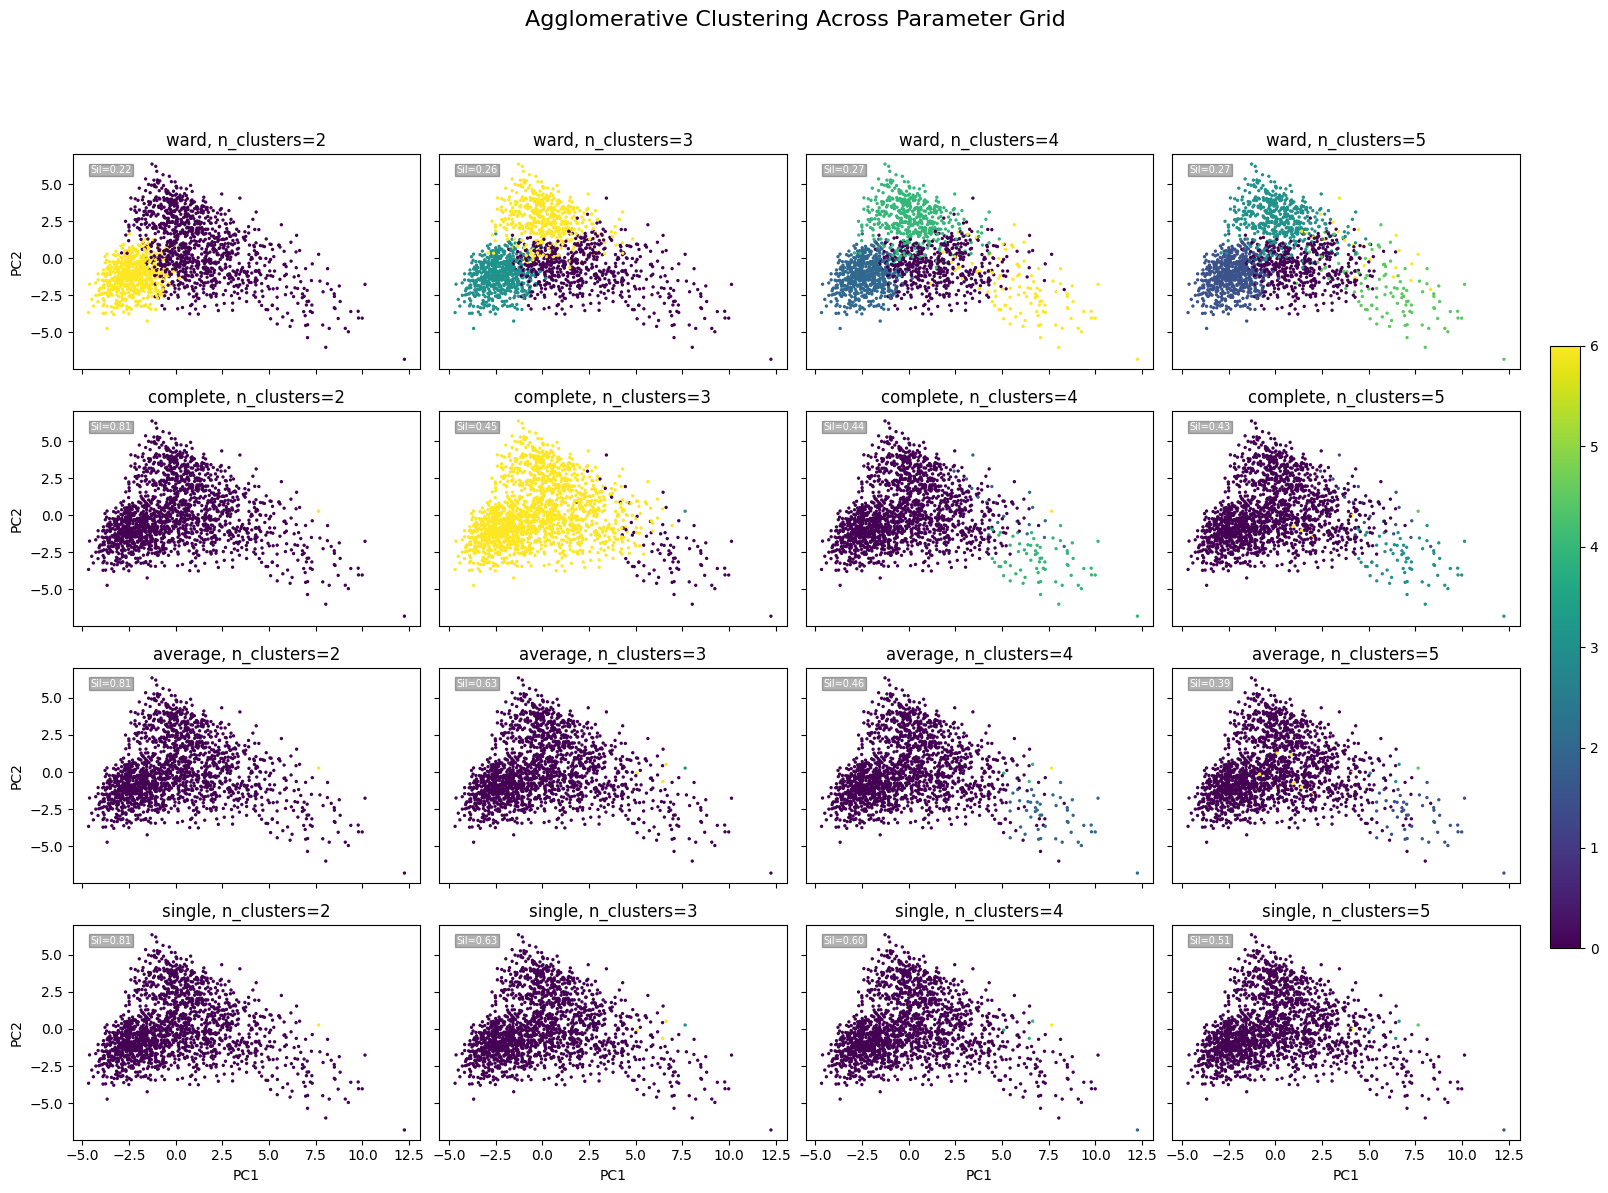

In [89]:
from sklearn.cluster import AgglomerativeClustering

n_clusters_list = [2, 3, 4, 5]
linkage_list = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(len(linkage_list), len(n_clusters_list), figsize=(16, 12), sharex=True, sharey=True)
plt.suptitle('Agglomerative Clustering Across Parameter Grid', fontsize=16, y=1.02)

for i, linkage in enumerate(linkage_list):
    for j, n_clusters in enumerate(n_clusters_list):
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        labels = model.fit_predict(data_pca_df[pc_columns])  # Use all 8 PCs
        ax = axes[i, j]
        ax.scatter(pc1, pc2, c=labels, cmap='viridis', s=2, alpha=1)
        ax.set_title(f'{linkage}, n_clusters={n_clusters}')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.label_outer()
        sil = silhouette_score(data_pca_df[pc_columns], labels)
        ax.text(0.05, 0.95, f'Sil={sil:.2f}', transform=ax.transAxes,
                fontsize=7, va='top', ha='left', color='white',
                bbox=dict(facecolor='black', alpha=0.3, pad=1))

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
fig.colorbar(scatter, ax=axes, fraction=0.02, pad=0.02)

plt.show()

We will then produce a dendogram for the most promising (highest silhouette but still somewhat reasonable clustering)

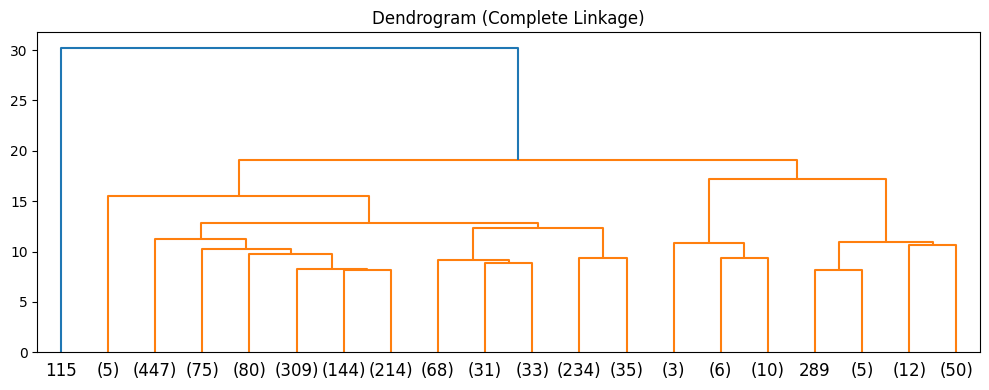

In [90]:
from scipy.cluster.hierarchy import dendrogram, linkage as scipy_linkage

Z = scipy_linkage(data_pca_df[pc_columns], method='complete')
plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode='lastp', p=20)
plt.title('Dendrogram (Complete Linkage)')
plt.tight_layout()
plt.show()

## What happened here?

 - The only ones with clear separation are the ward, and complete.
 - However, the ward has a very low silhouette score, and complete doesn't visually cluster the data at all.
 - We can use this to conclude that hierarchical clustering is not suitable for this dataset.

Now running DBSCAN

We should first use a k-distance plot find the best eps values

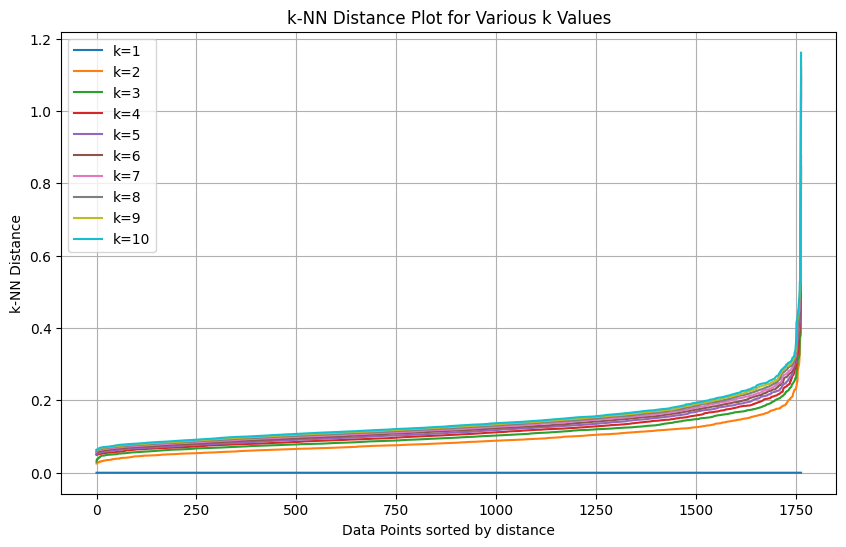

In [91]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

k_values =[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize=(10, 6))

from sklearn.preprocessing import MinMaxScaler
min_max_pca_df = pd.DataFrame(
    MinMaxScaler().fit_transform(data_pca_df[pc_columns]),
    columns=pc_columns
)



for k in k_values:
    neighbours = NearestNeighbors(n_neighbors=k)
    neighbours_fit = neighbours.fit(min_max_pca_df[pc_columns])
    distances, indices = neighbours_fit.kneighbors(min_max_pca_df[pc_columns])
    distances = np.sort(distances[:, k-1], axis=0)
    plt.plot(distances, label=f'k={k}')

plt.title('k-NN Distance Plot for Various k Values')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('k-NN Distance')
plt.legend()
plt.grid(True)
plt.show()

Now we must find the optimal eps value

In [92]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt


k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(min_max_pca_df[pc_columns])
distances, indices = neighbors_fit.kneighbors(min_max_pca_df[pc_columns])

k_distances = distances[: , -1]
k_distances = np.sort(k_distances)

differences = np.diff(k_distances)

elbow_index = np.argmax(differences) + 1

best_eps = k_distances[elbow_index]

print(f"Optimal eps value determined from k-NN distance plot: {best_eps:.4f}")

Optimal eps value determined from k-NN distance plot: 1.0482


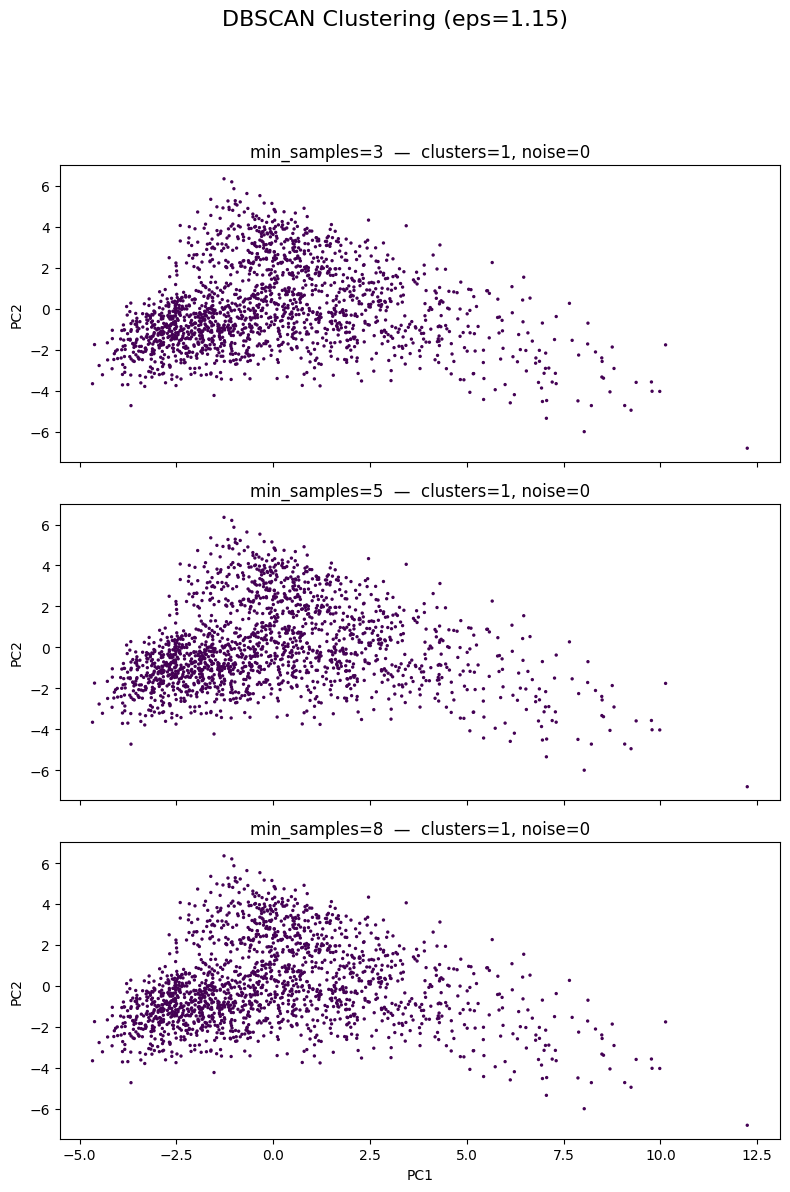

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

# Set a single eps value
eps = 1.15
min_samples_values = [3, 5, 8]



# Create subplots: one row per min_samples value
n_rows = len(min_samples_values)
fig, axes = plt.subplots(n_rows, 1, figsize=(8, 4 * n_rows), sharex=True, sharey=True)
plt.suptitle(f'DBSCAN Clustering (eps={eps})', fontsize=16, y=1.02)

for i, min_samples in enumerate(min_samples_values):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(min_max_pca_df[pc_columns])  # using all PCs in pc_columns

    # axes is a 1D array when n_rows > 1, else a single Axes object
    ax = axes[i] if n_rows > 1 else axes

    # Scatter using the first two principal components (pc1, pc2 assumed defined)
    ax.scatter(pc1, pc2, c=labels, cmap='viridis', s=2, alpha=1)

    # Compute cluster and noise counts
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # labels may be numpy array; use numpy sum for speed/robustness
    n_noise = int(np.sum(labels == -1))

    ax.set_title(f'min_samples={min_samples}  —  clusters={n_clusters}, noise={n_noise}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.label_outer()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()